# Config

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd '/content/drive/MyDrive/Credit Card Fraud Analysis'

/content/drive/MyDrive/Credit Card Fraud Analysis


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
!pip install pyspark
!pip install pretty_errors

In [9]:
from pyspark.sql import SparkSession
import os, sys
import plotly.express as px

In [10]:
from src.data_visualization import *

In [11]:
from config import PROJECT_PATH
import pretty_errors

In [12]:
train_dir = os.path.join(PROJECT_PATH, 'input/fraudTrain.csv')
test_dir = os.path.join(PROJECT_PATH, 'input/fraudTest.csv')

In [13]:
from pyspark.sql import functions as F

In [14]:
sc = SparkSession.builder \
    .appName("fraudDetection") \
    .config("spark.driver.maxResultSize", "3g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
train = sc.read.csv(train_dir, inferSchema = True, header = True)
test = sc.read.csv(test_dir, inferSchema = True, header = True)

In [15]:
all_data = train.union(test)
all_data.show()

+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|_c0|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|
+---+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+
|  0|  2019-01-01 00:00:18|   2703186189

# Data Cleaning

In [16]:
irrelevant_columns =  ['_c0', 'first', 'last', 'cc_num', 'trans_num', 'zip']
all_data = all_data.drop(*irrelevant_columns)
all_data.show()

+---------------------+--------------------+-------------+------+------+--------------------+--------------------+-----+-------+------------------+--------+--------------------+----------+----------+------------------+------------------+--------+
|trans_date_trans_time|            merchant|     category|   amt|gender|              street|                city|state|    lat|              long|city_pop|                 job|       dob| unix_time|         merch_lat|        merch_long|is_fraud|
+---------------------+--------------------+-------------+------+------+--------------------+--------------------+-----+-------+------------------+--------+--------------------+----------+----------+------------------+------------------+--------+
|  2019-01-01 00:00:18|fraud_Rippin, Kub...|     misc_net|  4.97|     F|      561 Perry Cove|      Moravian Falls|   NC|36.0788|          -81.1781|    3495|Psychologist, cou...|1988-03-09|1325376018|         36.011293|        -82.048315|       0|
|  2019-01-0

In [17]:
all_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in all_data.columns]).show()

+---------------------+--------+--------+---+------+------+----+-----+---+----+--------+---+---+---------+---------+----------+--------+
|trans_date_trans_time|merchant|category|amt|gender|street|city|state|lat|long|city_pop|job|dob|unix_time|merch_lat|merch_long|is_fraud|
+---------------------+--------+--------+---+------+------+----+-----+---+----+--------+---+---+---------+---------+----------+--------+
|                    0|       0|       0|  0|     0|     0|   0|    0|  0|   0|       0|  0|  0|        0|        0|         0|       0|
+---------------------+--------+--------+---+------+------+----+-----+---+----+--------+---+---+---------+---------+----------+--------+



In [18]:
all_data = all_data.dropDuplicates()

In [19]:
all_data = (
    all_data.withColumn('merchant', F.regexp_replace('merchant', 'fraud_', ''))
            .withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))
            .withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))
            .drop('dob', 'trans_date_trans_time')
)

all_data.show()

+--------------------+-------------+------+------+--------------------+-------------+-----+-------+------------------+--------+--------------------+----------+------------------+-------------------+--------+----+----------+
|            merchant|     category|   amt|gender|              street|         city|state|    lat|              long|city_pop|                 job| unix_time|         merch_lat|         merch_long|is_fraud| age|trans_hour|
+--------------------+-------------+------+------+--------------------+-------------+-----+-------+------------------+--------+--------------------+----------+------------------+-------------------+--------+----+----------+
|       Kutch-Hegmann|  grocery_net| 39.95|     M|  2970 Flores Brooks|    Smackover|   AR|33.3398|          -92.7442|    2501|   Financial adviser|1325380501|         33.651123|         -91.902918|       0|38.0|         1|
|    Pacocha-O'Reilly|  grocery_pos| 92.56|     F|   4038 Smith Avenue|        Jones|   AL|32.5104|     

# General info about the data

In [75]:
numerical_columns = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'age', 'trans_hour']
categorical_columns = ['category', 'job', 'state', 'merchant', 'gender', 'street', 'city', ]

In [22]:
all_data.select(numerical_columns).describe().show()

+-------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+
|summary|               amt|         city_pop|              lat|              long|        merch_lat|        merch_long|               age|        trans_hour|
+-------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+
|  count|           1852394|          1852394|          1852394|           1852394|          1852394|           1852394|           1852394|           1852394|
|   mean| 70.06356747538594|88643.67450931066|38.53931097924794|-90.22783229070546|38.53897596705964|-90.22793950913668|  50.7303737757734|12.806119000601385|
| stddev|159.25397477398397|301487.6183436511|5.071470391380596|13.747894882569105|5.105603877592824|13.759692112582865|17.404655569669885| 6.815752946133062|
|    min|               1.0|               23|

In [23]:
all_data.select('is_fraud').groupby('is_fraud').count().withColumn('percentage', F.col('count') / all_data.count()).show()

+--------+-------+--------------------+
|is_fraud|  count|          percentage|
+--------+-------+--------------------+
|       1|   9651|0.005210014716091717|
|       0|1842743|  0.9947899852839083|
+--------+-------+--------------------+



In [24]:
customers_cols = ['job', 'age', 'state', 'gender']
customers = all_data.select(customers_cols) \
                    .groupBy(customers_cols) \
                    .count() \
                    .withColumnRenamed('count', 'number_of_transactions')\
                    .orderBy('number_of_transactions', ascending = False)
customers.show()

+--------------------+----+-----+------+----------------------+
|                 job| age|state|gender|number_of_transactions|
+--------------------+----+-----+------+----------------------+
|      Energy manager|27.0|   PA|     F|                  4392|
|Environmental con...|52.0|   IL|     F|                  4392|
|        Immunologist|27.0|   NV|     M|                  4386|
|Engineer, control...|47.0|   AR|     F|                  4386|
|  Surveyor, minerals|37.0|   UT|     F|                  4386|
|Environmental con...|38.0|   FL|     F|                  4385|
| Electrical engineer|31.0|   AR|     F|                  4385|
|Psychologist, for...|26.0|   IN|     F|                  4384|
|Sales professiona...|27.0|   SC|     F|                  4384|
|        Tree surgeon|41.0|   PA|     F|                  4384|
|         Comptroller|34.0|   NY|     F|                  4384|
|  Petroleum engineer|37.0|   AZ|     F|                  4383|
|Claims inspector/...|26.0|   VT|     F|

In [25]:
# Total customers in the dataset
print(f'Total customers in the dataset is: {customers.count()}')

Total customers in the dataset is: 999


# Numerical columns

In [21]:
numerical_data = all_data.select(numerical_columns + ['is_fraud'])

Plotting histograms of columns: 100%|██████████| 8/8 [00:47<00:00,  5.92s/it]


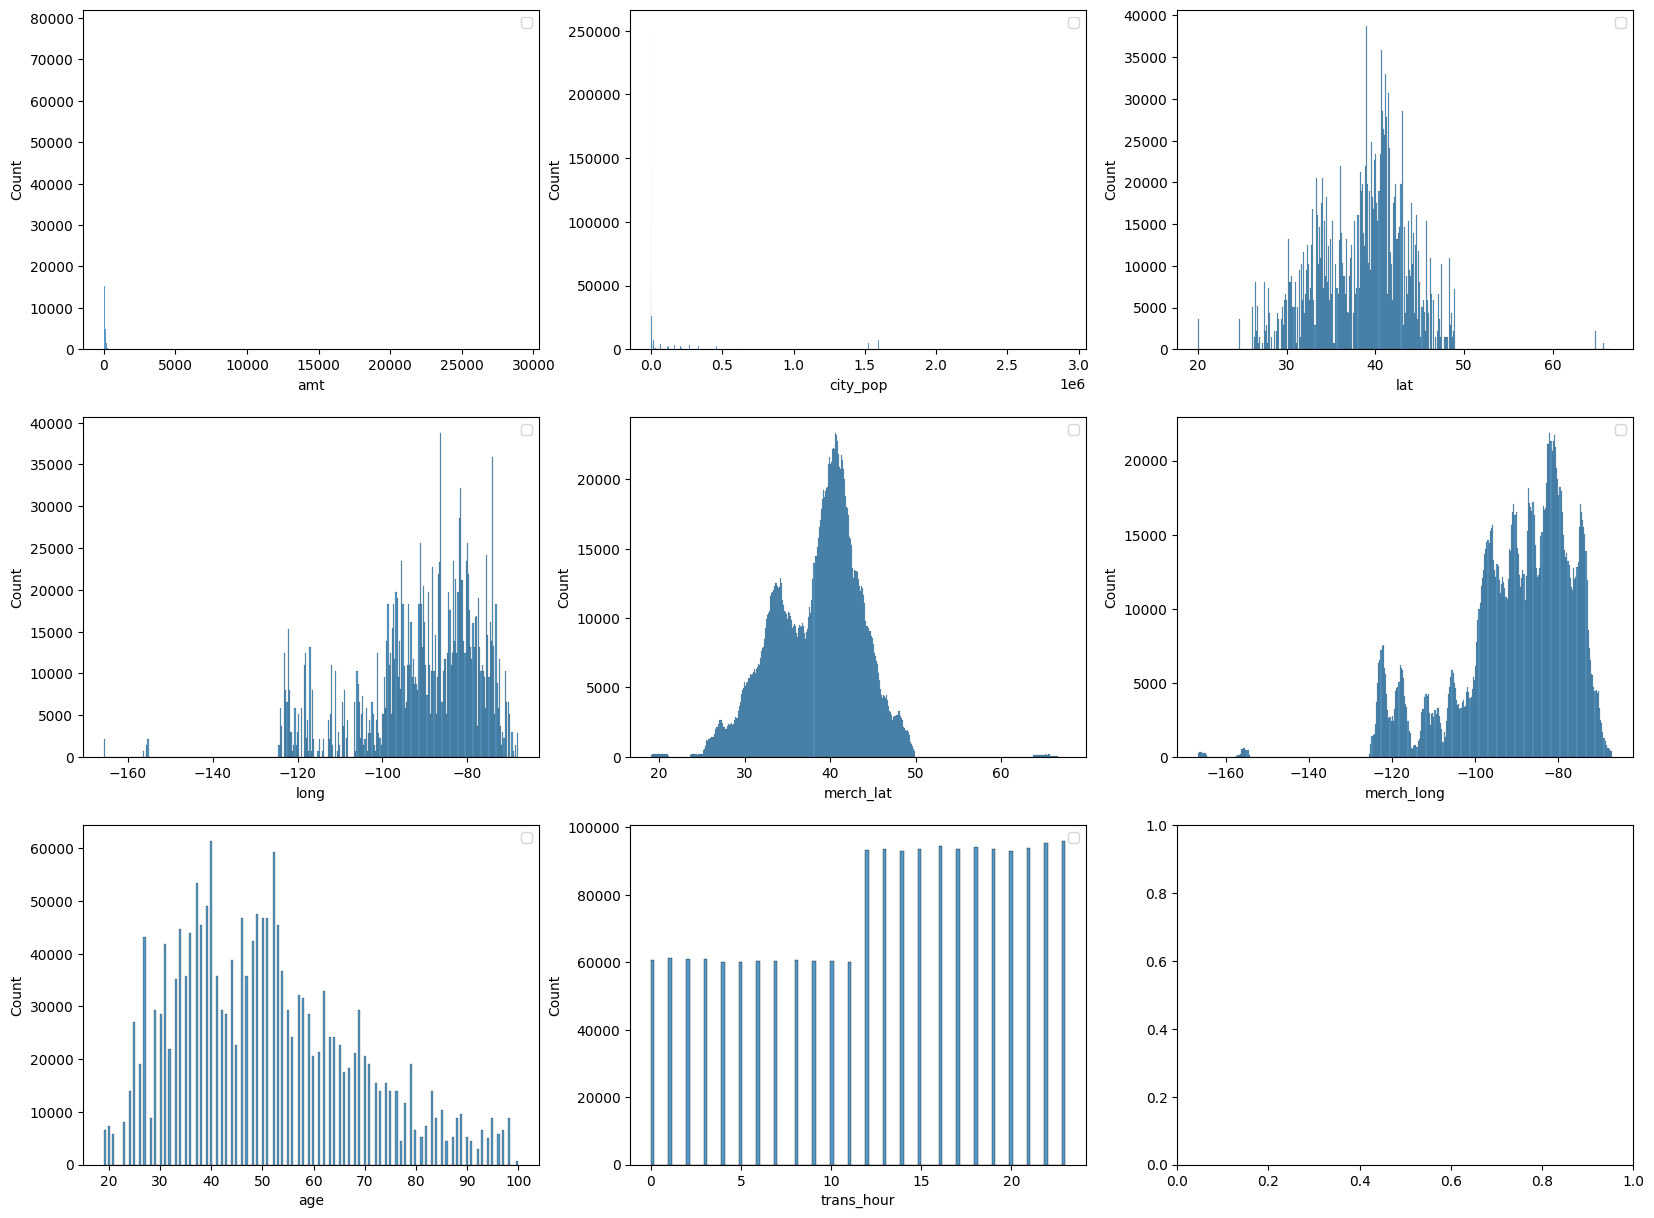

In [27]:
histograms(numerical_data.select(numerical_columns).toPandas(), shape = (3, 3), figsize = (20, 15))

`Wa can see that most of numerical columns follow the usual distirbution except amount and city_pop columns contain outliers and are right skewed, let's apply some transformation functions on these columns to deal with that problem`




In [22]:
numerical_data = numerical_data.withColumn('ln_amt', F.log(F.col('amt'))) \
                              .withColumn('sqrt_amt', F.sqrt(F.col('amt'))) \
                              .withColumn('log_city_pop', F.log(F.col('city_pop'))) \
                              .withColumn('sqrt_city_pop', F.sqrt(F.col('city_pop'))) \
                              .drop('amt', 'city_pop')

Plotting histograms of columns: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


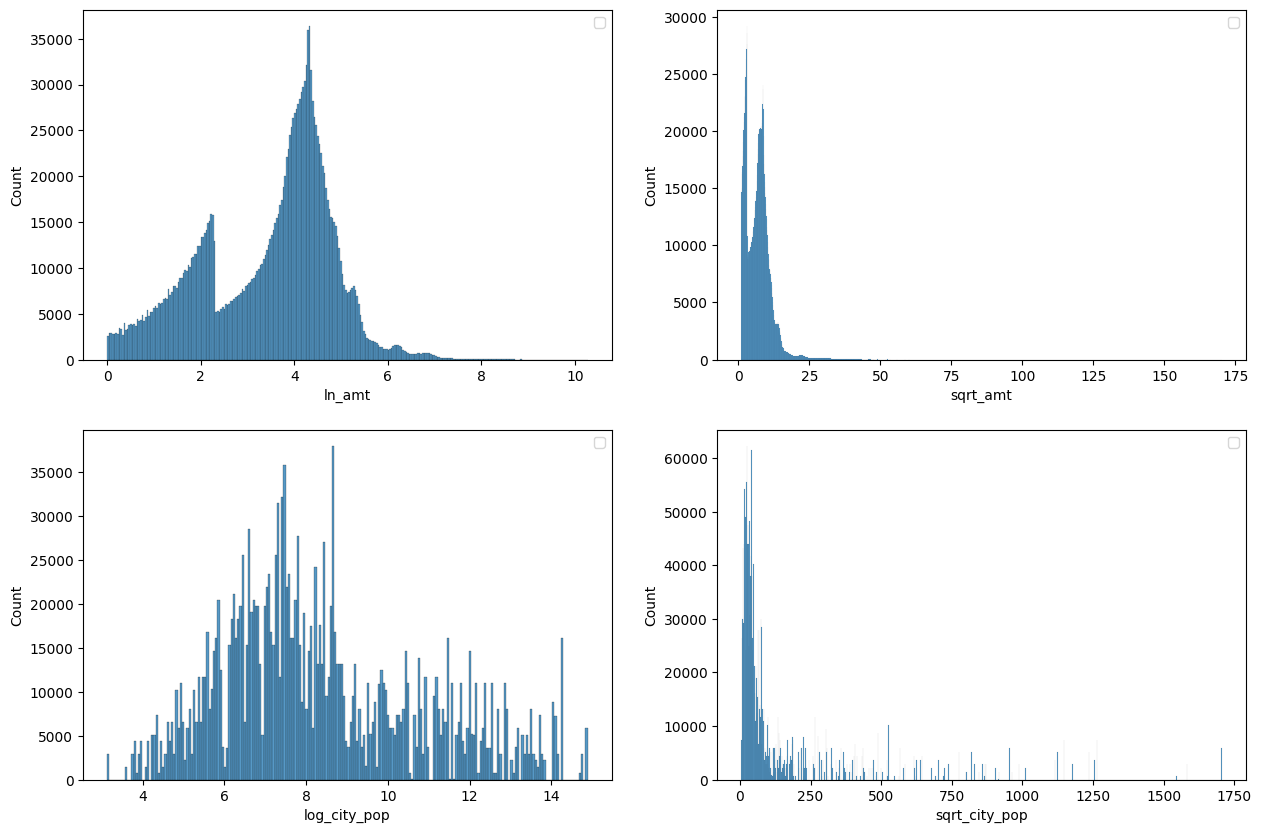

In [29]:
histograms(numerical_data.select('ln_amt', 'sqrt_amt', 'log_city_pop', 'sqrt_city_pop').toPandas(), shape = (2, 2), figsize = (15, 10))

`Logarithmic transformation is more suitable for skewed data in this case`

In [23]:
numerical_data = numerical_data.drop('sqrt_amt', 'sqrt_city_pop')

In [24]:
numerical_columns = [col_name for col_name in numerical_data.columns if col_name not in 'is_fraud']

Plotting histograms grouped by is_fraud: 100%|██████████| 8/8 [01:18<00:00,  9.78s/it]


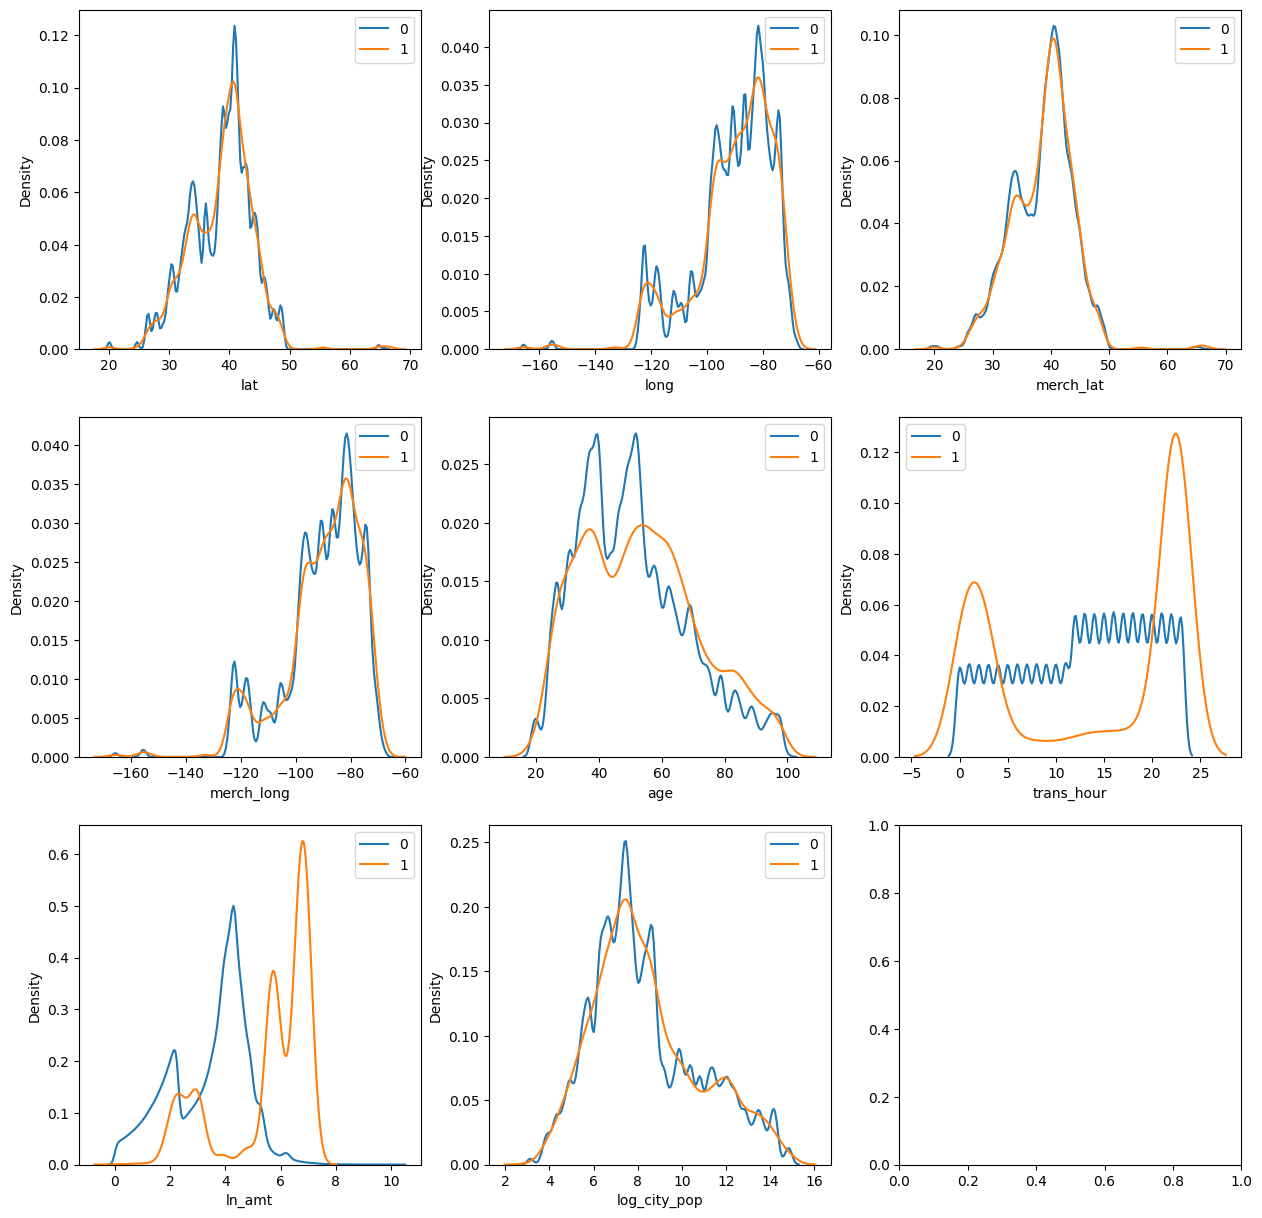

In [43]:
kdeplots(numerical_data.select(numerical_columns + ['is_fraud']).toPandas(),
           y = 'is_fraud',
           shape = (3, 3),
           figsize = (15, 15))

`log_amt and sqrt_amt are 2 columns to investigate more`

Let's generate more columns and apply polynomial transformation on these columns

In [25]:
numerical_data = numerical_data.withColumns({
    f'{column}**2': F.pow(F.col(column), 2) for column in numerical_columns if column != 'is_fraud'
})

In [26]:
from itertools import combinations

combinations = list(combinations(numerical_columns, 2))
for column1, column2 in combinations:
    numerical_data = numerical_data.withColumn(f'{column1}*{column2}', F.col(column1) * F.col(column2))

In [27]:
new_columns = [column for column in numerical_data.columns if '*' in column and '**' not in column]
len(new_columns)

28

Plotting histograms grouped by is_fraud: 100%|██████████| 9/9 [01:29<00:00,  9.89s/it]


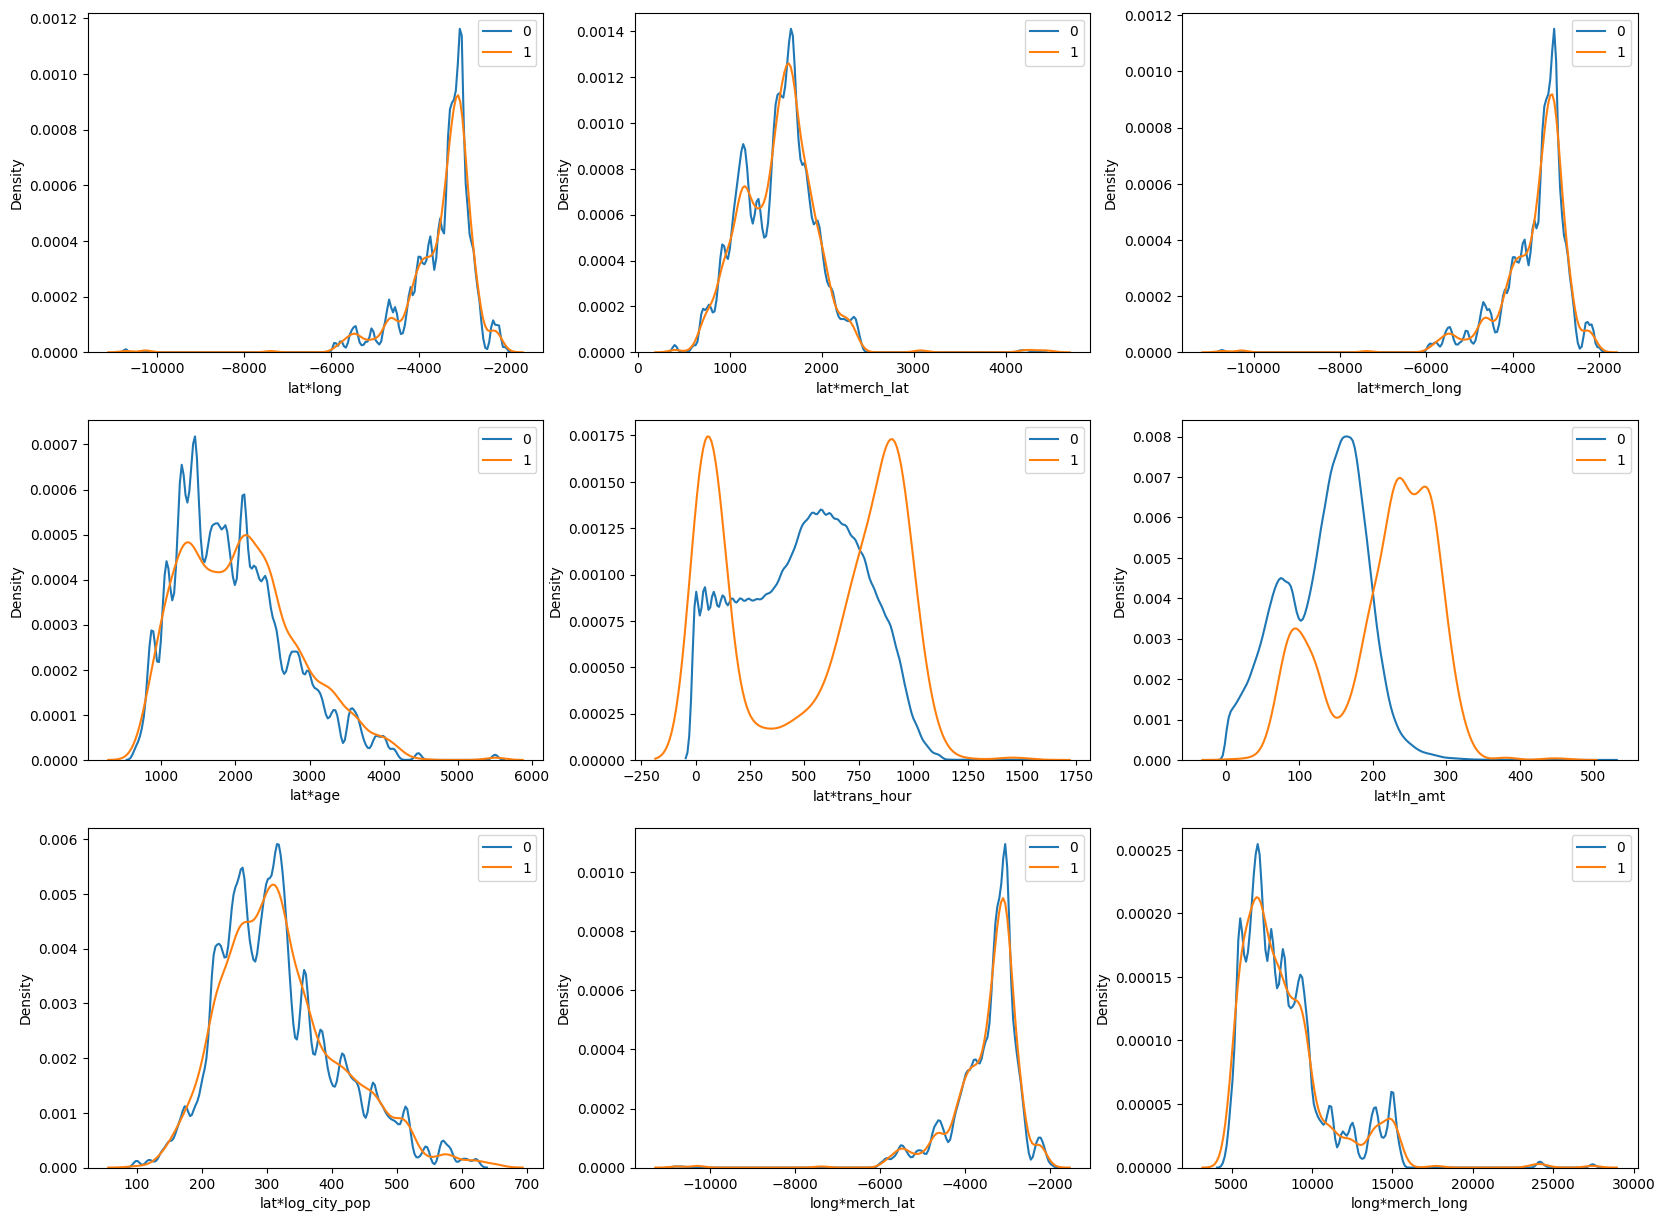

In [37]:
kdeplots(numerical_data.select(new_columns[:9] + ['is_fraud']).toPandas(),
         y = 'is_fraud',
         shape = (3, 3),
         figsize = (20, 15))

Plotting histograms grouped by is_fraud: 100%|██████████| 9/9 [01:28<00:00,  9.82s/it]


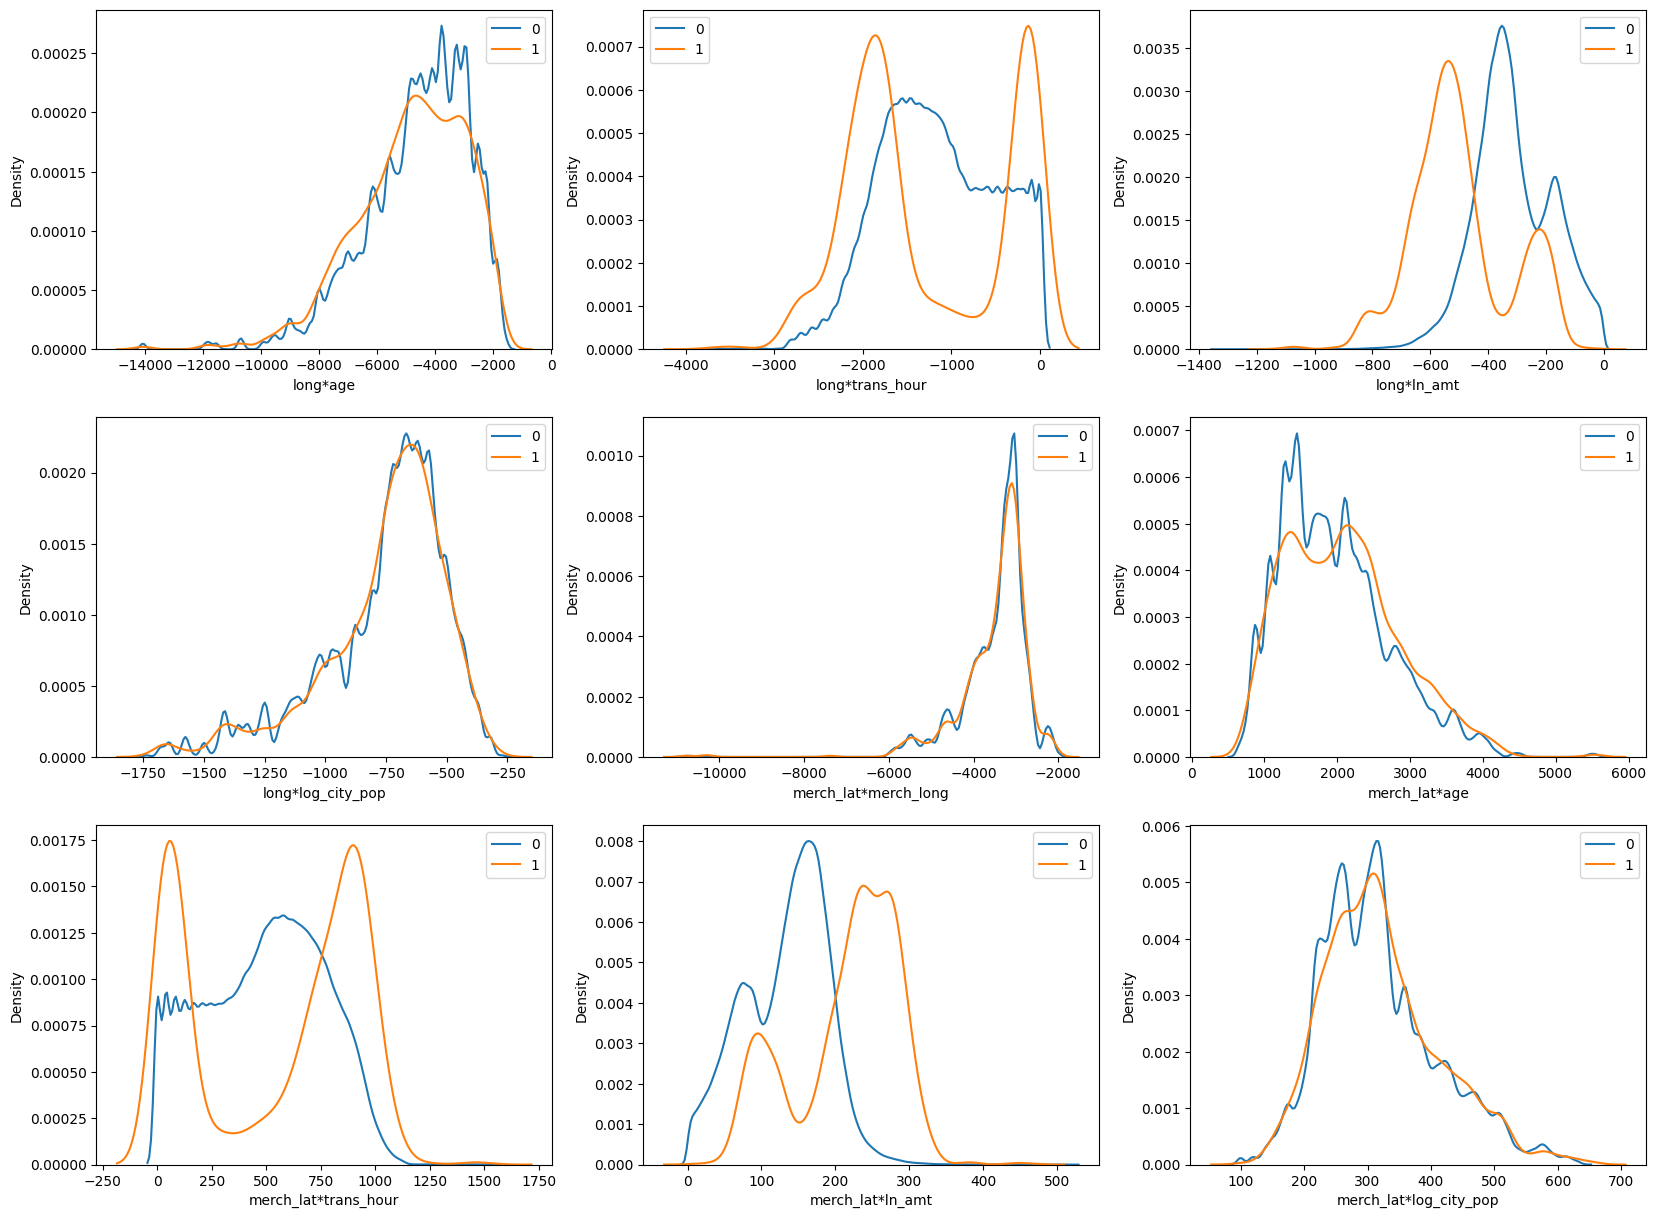

In [38]:
kdeplots(numerical_data.select(new_columns[9:18] + ['is_fraud']).toPandas(),
         y = 'is_fraud',
         shape = (3, 3),
         figsize = (20, 15))

Too much columns to investigate, let's perform statistical tests to measure the association between numerical columns and target

## Mann-Whitney U test for columns association

In [28]:
from scipy.stats import mannwhitneyu
from tqdm import tqdm

numerical_data_df = numerical_data.toPandas()
cols = [col for col in numerical_data.columns if col != 'is_fraud']

results_list = []
for col_name in tqdm(cols, desc = 'Mann-Whitney test'):

    y_values = numerical_data_df[numerical_data_df['is_fraud'] == 1][col_name]
    x_values = numerical_data_df[numerical_data_df['is_fraud'] == 0][col_name].sample(n = len(y_values))

    result = mannwhitneyu(x = x_values, y = y_values)
    results_list.append((col_name, result.statistic, result.pvalue))

results_df = pd.DataFrame(results_list, columns = ['column', 'statistic', 'pvalue'])
results_df.sort_values(by = 'pvalue', ascending = True)

Mann-Whitney test: 100%|██████████| 44/44 [00:20<00:00,  2.11it/s]


,column,statistic,pvalue
21,lat*ln_amt,17049885.5,0.000000e+00
39,age*ln_amt,22837156.0,0.000000e+00
36,merch_long*ln_amt,75346468.0,0.000000e+00
32,merch_lat*ln_amt,16887826.0,0.000000e+00
27,long*ln_amt,75755183.0,0.000000e+00
14,ln_amt**2,15472540.0,0.000000e+00
43,ln_amt*log_city_pop,22270187.5,0.000000e+00
6,ln_amt,15456844.0,0.000000e+00
41,trans_hour*ln_amt,33741466.5,6.030729e-241
13,trans_hour**2,38508300.0,3.790128e-97


In [33]:
len(results_df[results_df['pvalue'] < 0.05])

35

`Polynomial transformation may be a good idea to use when training the model`

#Categorical columns

In [47]:
categorical_columns

['category', 'job', 'state', 'merchant', 'gender', 'street', 'city']

In [50]:
for column in categorical_columns:
    distinct_count = all_data.select(column).distinct().count()
    print(f"Column: {column}, Distinct Count: {distinct_count}")

Column: category, Distinct Count: 14
Column: job, Distinct Count: 497
Column: state, Distinct Count: 51
Column: merchant, Distinct Count: 693
Column: gender, Distinct Count: 2
Column: street, Distinct Count: 999
Column: city, Distinct Count: 906


Plotting barplots: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


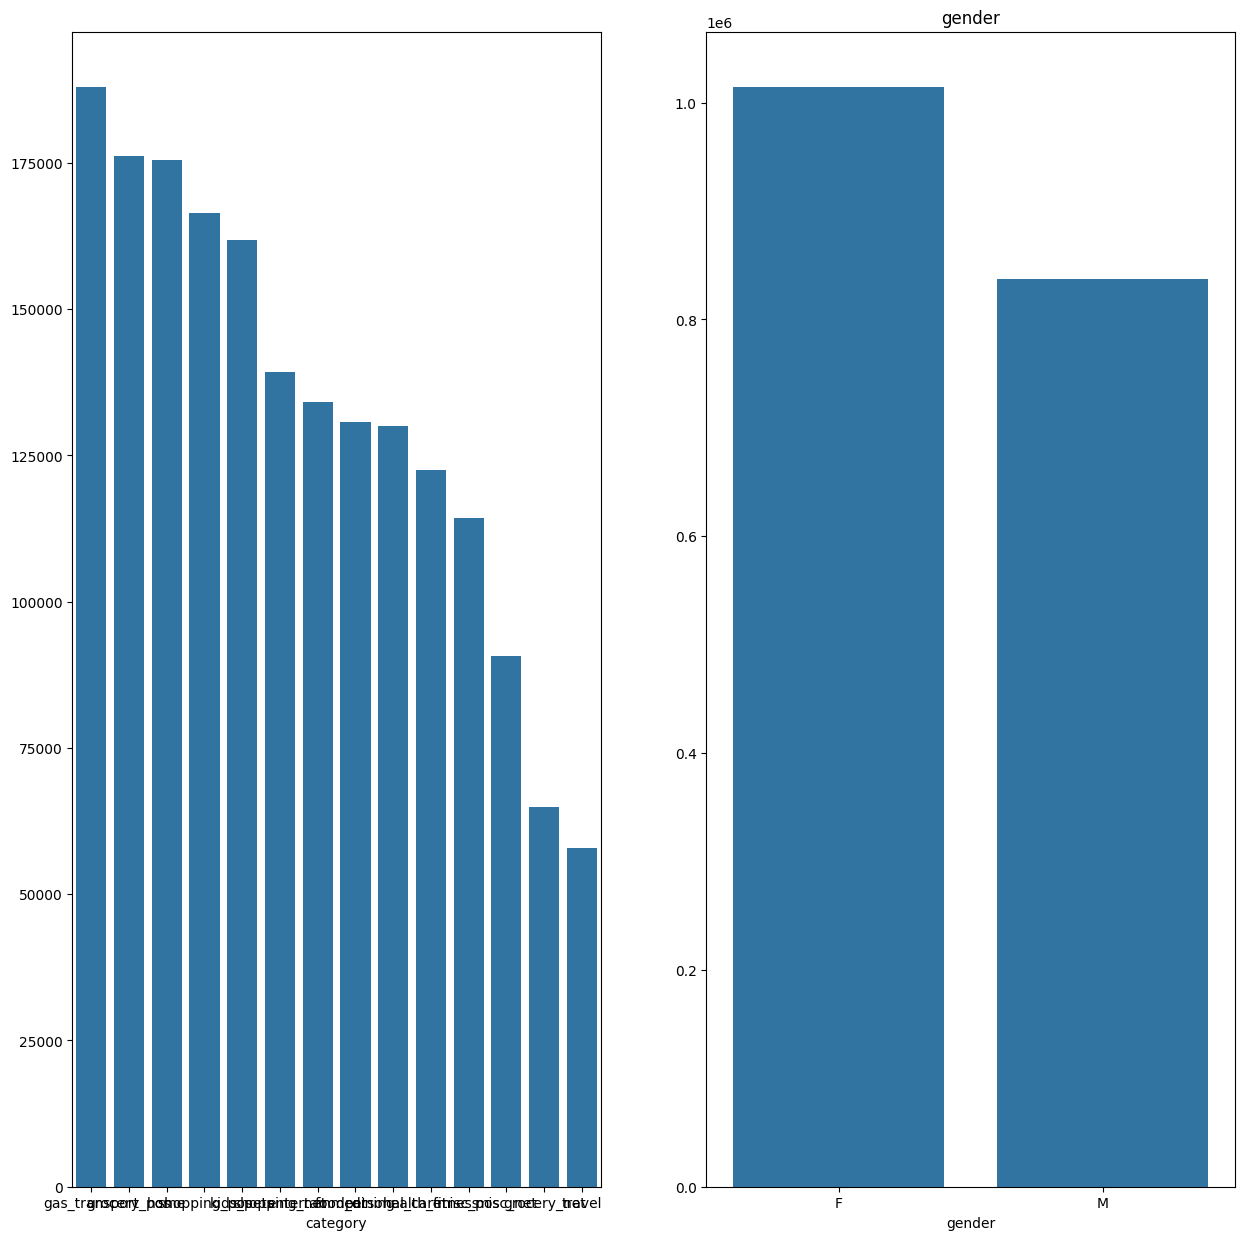

In [52]:
barplots(all_data.select(['category', 'gender']).toPandas(),
         columns = ['category', 'gender'],
         shape = (1, 2),
         figsize = (15, 15))

In [66]:
job_counts = all_data.select('job').groupby('job').count().withColumn('percentage', F.col('count') / all_data.count()).orderBy('count', ascending = True)
job_counts.show()

+--------------------+-----+--------------------+
|                 job|count|          percentage|
+--------------------+-----+--------------------+
|         Ship broker|    7|3.778893691082998...|
|   Warehouse manager|    7|3.778893691082998...|
|Contracting civil...|    7|3.778893691082998...|
|     Engineer, water|    8|4.318735646951999E-6|
|  Veterinary surgeon|    8|4.318735646951999E-6|
| Information officer|    8|4.318735646951999E-6|
|Armed forces tech...|    8|4.318735646951999E-6|
|Broadcast journalist|    9|4.858577602820998E-6|
|Forest/woodland m...|    9|4.858577602820998E-6|
|    Industrial buyer|   10|5.398419558689998E-6|
|Operational inves...|   11|5.938261514558998E-6|
|   Software engineer|   11|5.938261514558998E-6|
|Accountant, chart...|   11|5.938261514558998E-6|
|           Solicitor|   11|5.938261514558998E-6|
|           Homeopath|   11|5.938261514558998E-6|
|   Personnel officer|   12|6.478103470427997E-6|
|      Engineer, site|   12|6.478103470427997E-6|


In [73]:
job_counts.orderBy('count', ascending = False).show()

+--------------------+-----+--------------------+
|                 job|count|          percentage|
+--------------------+-----+--------------------+
|   Film/video editor|13898|0.007502723502667359|
| Exhibition designer|13167| 0.00710809903292712|
|Surveyor, land/ge...|12436|0.006713474563186881|
|     Naval architect|12434|0.006712394879275143|
|  Materials engineer|11711|0.006322089145181...|
|Designer, ceramic...|11688|0.006309672780196...|
|Environmental con...|10974|0.005924225623706403|
|   Financial adviser|10963|0.005918287362191845|
|   Systems developer|10962|0.005917747520235976|
|          IT trainer|10943|0.005907490523074...|
|Copywriter, adver...|10241|0.005528521470054427|
|Scientist, audiol...|10234|0.005524742576363344|
|Chartered public ...|10211|0.005512326211378357|
|Chief Executive O...|10199|0.005505848107907929|
|          Podiatrist| 9525|0.005141994629652223|
|         Comptroller| 9515|0.005136596210093533|
|Magazine features...| 9506|0.005131737632490712|


# Saving the data

In [77]:
train = (
    train.withColumn('merchant', F.regexp_replace('merchant', 'fraud_', ''))
            .withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))
            .withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))
            .drop('dob', 'trans_date_trans_time')
)

test = (
    test.withColumn('merchant', F.regexp_replace('merchant', 'fraud_', ''))
            .withColumn('age', F.round(F.datediff(F.current_date(), F.col('dob')) / 365))
            .withColumn('trans_hour', F.hour(F.to_timestamp(F.col('trans_date_trans_time'))))
            .drop('dob', 'trans_date_trans_time')
)

In [79]:
numerical_columns, categorical_columns

(['amt',
  'city_pop',
  'lat',
  'long',
  'merch_lat',
  'merch_long',
  'age',
  'trans_hour'],
 ['category', 'job', 'state', 'merchant', 'gender', 'street', 'city'])

In [81]:
train = train.select(['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'state', 'merchant', 'category', 'is_fraud'])
test = test.select(['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long', 'age', 'trans_hour', 'state', 'merchant', 'category', 'is_fraud'])

In [83]:
train.write.parquet(os.path.join(PROJECT_PATH, 'input/train.parquet'))
test.write.parquet(os.path.join(PROJECT_PATH, 'input/test.parquet'))